# Sign Language Translator: Model Experimentation
This notebook is dedicated to experimenting with various model architectures, training strategies, and evaluation methods for the Sign Language Translator project.
We explore how different preprocessing techniques and model choices affect the performance of our sign language recognition system.

## Library Imports
We begin by importing the necessary libraries and custom modules.
These include TensorFlow for model building and training, custom preprocessing pipelines, visualizers for data and predictions, and utilities for dataset management.

In [1]:
import sys
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

from Src import \
        SignLanguageModel, \
        PreprocessingPipeline, \
        Visualizer, \
        DatasetSplitter

from config import \
        CLASSES_LIST, \
        MODEL_PATH, \
        INPUT_SHAPE, \
        IMAGE_SIZE, \
        MODEL_PATH, \
        BATCH_SIZE, \
        TRAIN_PROPORTION, \
        OPTIMIZER, \
        LOSS, \
        METRICS

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Preprocessing and Visualization Setup
We initialize the preprocessing pipeline and visualization tools.
The preprocessing pipeline handles tasks like resizing, normalizing, and augmenting the images, while the visualizer helps in displaying images and predictions.

In [2]:
prep_pipeline_func = PreprocessingPipeline(target_size=IMAGE_SIZE, is_gray=False)
visualizer_tf_data = Visualizer(figsize_per_image=(2,2))
splitter = DatasetSplitter(batch_size=BATCH_SIZE, train_split=TRAIN_PROPORTION)

## Data Loading
The training and testing datasets are loaded from pre-saved TFRecord files.
TFRecord is a highly efficient format that allows for fast data loading, which is particularly beneficial when working with large datasets.

In [3]:
sibi_train_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_train_dataset.tfrecord", compression="GZIP")
sibi_test_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_test_dataset.tfrecord", compression="GZIP")

## Data Augmentation
To improve the robustness of our model, we apply data augmentation techniques to the training dataset.
This involves random transformations such as rotations, flips, and shifts, which help the model generalize better to unseen data.

In [4]:
print(f'info train data: {sibi_train_dataset_loaded}')
print(f'number of train data: {len(sibi_train_dataset_loaded)}')
print()
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of train data: 5200

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [5]:
sibi_train_dataset_augmented = sibi_train_dataset_loaded.map(prep_pipeline_func.augment_image)
sibi_train_dataset_cached = sibi_train_dataset_augmented.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 1)
    dtype-image: <dtype: 'float32'>
    max-intensity: 0.9043851494789124
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: I
    label-shape: (26,)
    image-type: <dtype: 'float32'>


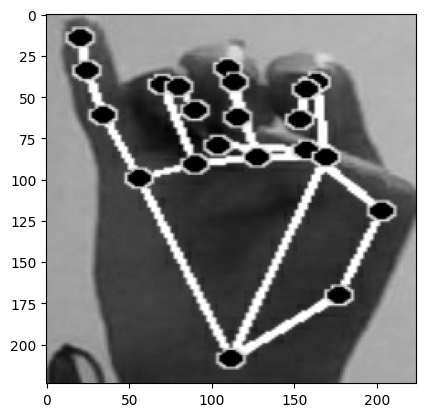

In [6]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_cached.shuffle(buffer_size=sibi_train_dataset_cached.cardinality().numpy()).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

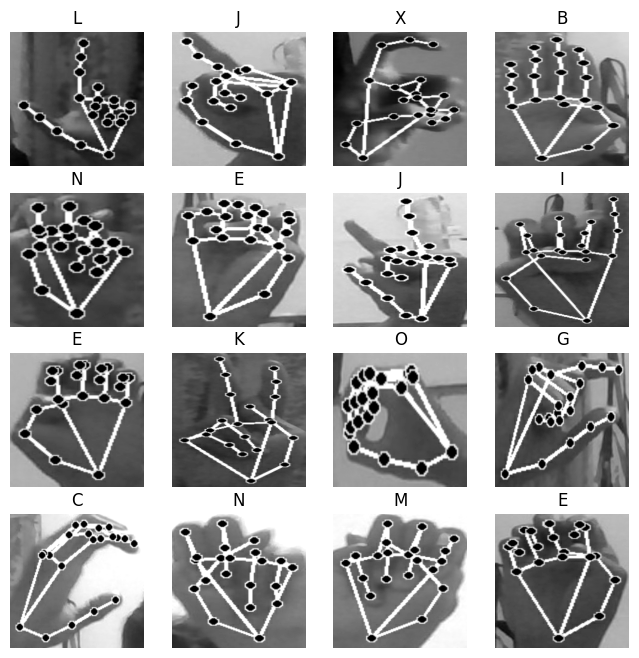

In [7]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_train_dataset_cached, num_images=16, classes_list=CLASSES_LIST)

In [8]:
train_dataset_batched, valid_dataset_batched = splitter.split_and_prepare(sibi_train_dataset_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Training Split: 0.9
Number of data: 4680
AFTER BATCH: 32
Number of data: 147
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Validation Split: 0.1
Number of data: 520
AFTER BATCH: 32
Number of data: 17


In [9]:
sibi_train_dataset_3_channels = train_dataset_batched.map(prep_pipeline_func.processing_data_train_to_VGG_input)
sibi_valid_dataset_3_channels = valid_dataset_batched.map(prep_pipeline_func.processing_data_train_to_VGG_input)

sibi_train_dataset_3_channels_cached = sibi_train_dataset_3_channels.cache()
sibi_valid_dataset_3_channels_cached = sibi_valid_dataset_3_channels.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 0.8108764886856079
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: K
    label-shape: (26,)
    image-type: <dtype: 'float32'>


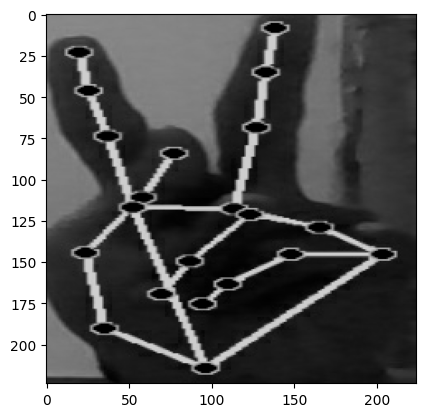

In [10]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_3_channels_cached.shuffle(buffer_size=sibi_train_dataset_3_channels_cached.cardinality().numpy()).take(1):
    image, label = image[0], label[0]
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

## Model Architecture
We experiment with different model architectures, including EfficientNetB0 and VGG16.
These models are either trained from scratch or fine-tuned using transfer learning to adapt to the sign language classification task.

In [11]:
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

In [12]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
my_model=SignLanguageModel(
    input_shape=INPUT_SHAPE, 
    num_classes=len(CLASSES_LIST), 
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,046,362 (57.40 MB)

 Trainable params: 331,674 (1.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training and Validation
The models are trained using the augmented training dataset, and their performance is validated on the test dataset. 
Key metrics such as accuracy, loss, and learning curves are monitored to ensure the model is learning effectively.

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=25,
  restore_best_weights=True,
  verbose=1
)

history = my_model.train(
    sibi_train_dataset_3_channels_cached,
    validation_data=sibi_valid_dataset_3_channels_cached,
    epochs=300,
    callbacks=[
    plateau_callback,
    early_stopping,
    checkpoint_callback
  ]
)

In [14]:
load_model=SignLanguageModel(model_path=MODEL_PATH)

## Model Evaluation
After training, we evaluate the model's performance using a confusion matrix and classification report.
These tools provide insights into how well the model is distinguishing between different sign language classes.

In [16]:
# Evaluasi model yang dimuat
loaded_evaluation = load_model.model.evaluate(sibi_valid_dataset_3_channels_cached)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

In [17]:
def evaluate_model(model, test_dataset, class_names):
  """
  Evaluate the model using confusion matrix, classification report, and other metrics.
  
  Args:
  - model: Trained Keras model.
  - test_dataset: tf.data.Dataset for evaluation.
  - class_names: List of class names corresponding to the labels.
  """
  # Extract the true labels and predicted labels
  y_true = []
  y_pred = []

  for images, labels in test_dataset:
      predictions = model.predict(images, verbose=0)
      y_true.extend(tf.argmax(labels, axis=1).numpy())
      y_pred.extend(tf.argmax(predictions, axis=1).numpy())

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Display confusion matrix with class names
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # Print classification report with class names
  print("Classification Report:")
  print(classification_report(y_true, y_pred))

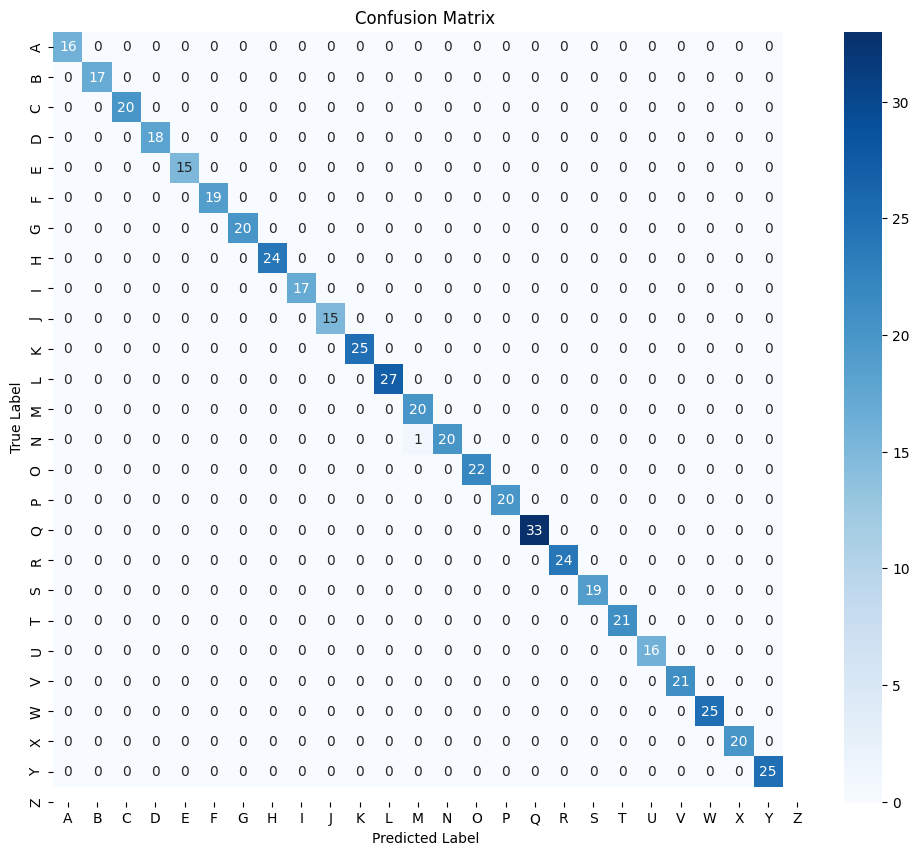

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        27
          12       0.95      1.00      0.98        20
          13       1.00      0.95      0.98        21
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        33
    

In [71]:
evaluate_model(load_model.model, sibi_valid_dataset_3_channels_cached, CLASSES_LIST)

## Visualization of Predictions
We visualize the model's predictions on the test dataset to see how well it performs on individual examples.
This helps in identifying strengths and weaknesses in the model's predictions and guides further improvements.

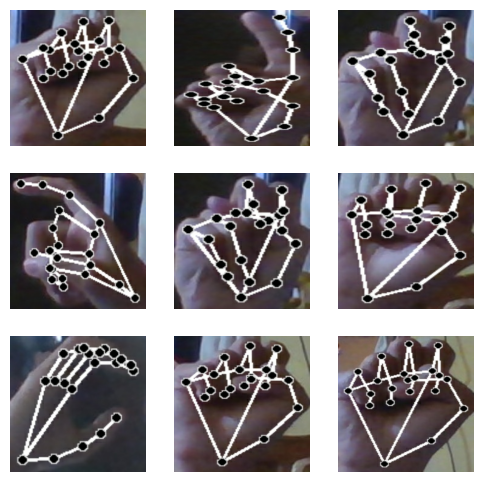

In [18]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_test_dataset_loaded, num_images=9)

In [19]:
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [20]:
sibi_test_dataset_loaded_rgb = sibi_test_dataset_loaded.map(prep_pipeline_func.processing_data_test_to_VGG_input)
sibi_test_dataset_loaded_rgb_cached = sibi_test_dataset_loaded_rgb.cache()

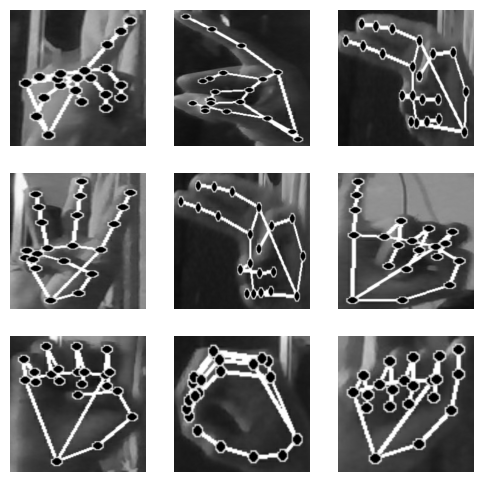

In [21]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_test_dataset_loaded_rgb_cached, num_images=9)

In [9]:
print(f'info test data: {sibi_test_dataset_loaded_rgb_cached}')
print(f'number of test data: {len(sibi_test_dataset_loaded_rgb_cached)}')

info test data: <CacheDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


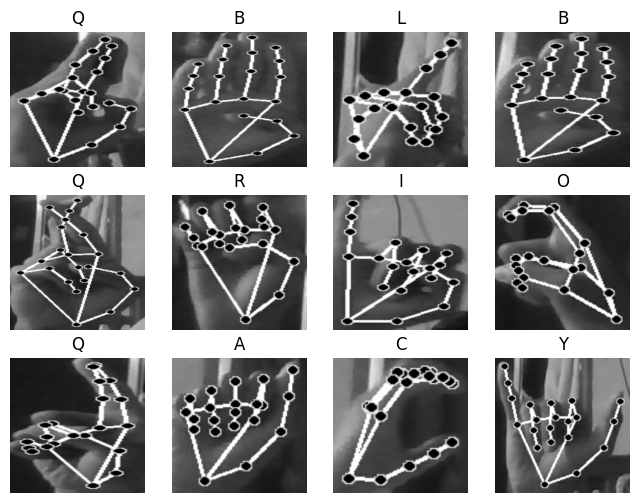

In [27]:
visualizer_tf_data.show_multiple_images_with_label_pred_tf_data(model=load_model.model, dataset=sibi_test_dataset_loaded_rgb_cached, num_images=12, classes_list=CLASSES_LIST)

## Conclusion and Future Work
This notebook explored various approaches to building and evaluating a sign language translation model.
Future work could include experimenting with more advanced architectures, fine-tuning hyperparameters, and expanding the dataset for better generalization.